# Seq 2 Seq - Text Generation

In this notebook we will look at 3 different examples:

1. Building a Seq2Seq model for machine translation using RNNs with and without Attention

[Return to Top](#returnToTop)  
<a id = 'setup'></a>

## 1. Setup

We first need to do the usual setup. We will also use some nltk and sklearn components in order to tokenize the text.

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally. This can also be done on Colab.

In [1]:
!pip install pydot --quiet
!pip install transformers --quiet
!pip install sentencepiece --quiet
!pip install nltk --quiet
!pip install tensorflow_datasets --quiet

In [2]:
import os
import re
import nltk

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# download
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ktrin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 2. Data
seq2seq model will use http://www.manythings.org as the source for the parallel corpus. The model will learn to translate English to German. For book keeping, some parameters are initialize:
- Embedded dimension
- Number of samples
- Vocab size

In [4]:
!!curl -O http://www.manythings.org/anki/deu-eng.zip
!!unzip deu-eng.zip

["'unzip' is not recognized as an internal or external command,",
 'operable program or batch file.']

In [5]:
embed_dim = 100  # Embedding dimensions for vectors and LSTMs.
num_samples = 10000  # Number of examples to consider.

# Path to the data txt file on disk.
data_path = "../data/deu.txt"

# Vocabulary sizes that we'll use:
english_vocab_size = 2000
german_vocab_size = 3000

In [6]:
# formatting the input text
# using sklearn CountVectorize to create a vocabulary from the most frequent word in each language
input_texts = []
target_texts = []

max_input_length = -1
max_output_length = -1

# open the file, split by line
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    
# for each line, grab the english/german correspondence
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")

    # use NLTK to tokenize the line of text
    tokenized_source_text = nltk.word_tokenize(input_text, language='english')
    tokenized_target_text = nltk.word_tokenize(target_text, language='german')

    # determine the max length of a sentence in english/german
    if len(tokenized_source_text) > max_input_length:
        max_input_length = len(tokenized_source_text)

    if len(tokenized_target_text) > max_output_length:
        max_output_length = len(tokenized_target_text)

    # break sentence to token
    source_text = (' '.join(tokenized_source_text)).lower()
    target_text = (' '.join(tokenized_target_text)).lower()

    input_texts.append(source_text)
    target_texts.append(target_text)

# determine vocab
vectorizer_english = CountVectorizer(max_features=english_vocab_size)
vectorizer_english.fit(input_texts)
vocab_english = vectorizer_english.get_feature_names()

vectorizer_german = CountVectorizer(max_features=german_vocab_size)
vectorizer_german.fit(target_texts)
vocab_german = vectorizer_german.get_feature_names()

print('Maximum source input length: ', max_input_length)
print('Maximum target output length: ', max_output_length)
print(f'English Vocab Size: {len(vocab_english)}')
print(f'German Vocab Size: {len(vocab_german)}')

Maximum source input length:  6
Maximum target output length:  11
English Vocab Size: 2000
German Vocab Size: 3000


C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
input_texts[:2]

['go .', 'hi .']

In [8]:
target_texts[:2]

['geh .', 'hallo !']

So the source and target sequences have max lengths 6 and 11, respectively. As we will add start and end tokens to our decoder side we will set the respective max lengths to:

In [9]:
max_encoder_seq_length = 6
max_decoder_seq_length = 13 #11 + start + end

In [10]:
# creating dictionaries to translate from token to an id for both source (English) and target (German)

source_id_vocab_dict = {}
source_vocab_id_dict = {}

for sid, svocab in enumerate(vocab_english):
    source_id_vocab_dict[sid] = svocab
    source_vocab_id_dict[svocab] = sid

source_id_vocab_dict[english_vocab_size] = "<unk>"
source_id_vocab_dict[english_vocab_size + 1] = "<pad>"

source_vocab_id_dict["<unk>"] = english_vocab_size
source_vocab_id_dict["<pad>"] = english_vocab_size + 1

target_id_vocab_dict = {}
target_vocab_id_dict = {}

for tid, tvocab in enumerate(vocab_german):
    target_id_vocab_dict[tid] = tvocab
    target_vocab_id_dict[tvocab] = tid

# Add unknown token plus start and end tokens to target language

target_id_vocab_dict[german_vocab_size] = "<unk>"
target_id_vocab_dict[german_vocab_size + 1] = "<start>"
target_id_vocab_dict[german_vocab_size + 2] = "<end>"
target_id_vocab_dict[german_vocab_size + 3] = "<pad>"

target_vocab_id_dict["<unk>"] = german_vocab_size
target_vocab_id_dict["<start>"] = german_vocab_size + 1
target_vocab_id_dict["<end>"] = german_vocab_size + 2
target_vocab_id_dict["<pad>"] = german_vocab_size + 3

In [11]:
# creating train/test set
def convert_text_to_data(texts, 
                         vocab_id_dict, 
                         max_length=20, 
                         type=None,
                         train_test_vector=None,
                         samples=100000):
  
    if type == None:
        raise ValueError('\'type\' is not defined. Please choose from: input_source, input_target, output_target.')

    train_data = []
    test_data = []

    for text_num, text in enumerate(texts[:samples]):

        sentence_ids = []

        for token in text.split():

            if token in vocab_id_dict.keys():
                sentence_ids.append(vocab_id_dict[token])
            else:
                sentence_ids.append(vocab_id_dict["<unk>"])
    
        vocab_size = len(vocab_id_dict.keys())

        # Depending on encoder/decoder and input/output, add start/end tokens.
        # Then add padding.

        if type == 'input_source':
            ids = (sentence_ids + [vocab_size - 1] * max_length)[:max_length]

        elif type == 'input_target':
            ids = ([vocab_size -3] + sentence_ids + [vocab_size - 2] + [vocab_size - 1] * max_length)[:max_length]

        elif type == 'output_target':
            ids = (sentence_ids + [vocab_size - 2] + [vocab_size -1] * max_length)[:max_length]

        if train_test_vector is not None and not train_test_vector[text_num]:
            test_data.append(ids)
        else:
            train_data.append(ids)

    return np.array(train_data), np.array(test_data)


train_test_split_vector = (np.random.uniform(size=10000) > 0.2)

train_source_input_data, test_source_input_data = convert_text_to_data(input_texts, 
                                                                       source_vocab_id_dict,
                                                                       type='input_source',
                                                                       max_length=max_encoder_seq_length,
                                                                       train_test_vector=train_test_split_vector)

train_target_input_data, test_target_input_data = convert_text_to_data(target_texts,
                                                                       target_vocab_id_dict,
                                                                       type='input_target',
                                                                       max_length=max_decoder_seq_length,
                                                                       train_test_vector=train_test_split_vector)

train_target_output_data, test_target_output_data = convert_text_to_data(target_texts,
                                                                         target_vocab_id_dict,
                                                                         type='output_target',
                                                                         max_length=max_decoder_seq_length,
                                                                         train_test_vector=train_test_split_vector)


In [12]:
train_source_input_data[:2]

array([[ 749, 2000, 2001, 2001, 2001, 2001],
       [ 843, 2000, 2001, 2001, 2001, 2001]])

In [13]:
train_target_input_data[:2]

array([[3001, 1080, 3000, 3002, 3003, 3003, 3003, 3003, 3003, 3003, 3003,
        3003, 3003],
       [3001, 1247, 3000, 3002, 3003, 3003, 3003, 3003, 3003, 3003, 3003,
        3003, 3003]])

In [14]:
train_target_output_data[:2]

array([[1080, 3000, 3002, 3003, 3003, 3003, 3003, 3003, 3003, 3003, 3003,
        3003, 3003],
       [1247, 3000, 3002, 3003, 3003, 3003, 3003, 3003, 3003, 3003, 3003,
        3003, 3003]])

# 3. Seq2Seq Model without Attention
The model has both encoder and decoder architecture. Using LSTM to link the two

In [22]:
def create_translation_model_no_att(encode_vocab_size, decode_vocab_size, embed_dim):

    source_input_no_att = tf.keras.layers.Input(shape=(max_encoder_seq_length,),
                                                dtype='int64',
                                                name='source_input_no_att')
    
    target_input_no_att = tf.keras.layers.Input(shape=(max_decoder_seq_length,),
                                                dtype='int64',
                                                name='target_input_no_att')

    source_embedding_layer_no_att = tf.keras.layers.Embedding(input_dim=encode_vocab_size,
                                                              output_dim=embed_dim,
                                                              name='source_embedding_layer_no_att')

    target_embedding_layer_no_att  = tf.keras.layers.Embedding(input_dim=decode_vocab_size,
                                                               output_dim=embed_dim,
                                                               name='target_embedding_layer_no_att')

    source_embeddings_no_att = source_embedding_layer_no_att(source_input_no_att)
    target_embeddings_no_att = target_embedding_layer_no_att(target_input_no_att)

    encoder_lstm_layer_no_att = tf.keras.layers.LSTM(embed_dim, return_sequences=True, return_state=True, name='encoder_lstm_layer_no_att')
    encoder_out_no_att, encoder_state_h_no_att, encoder_state_c_no_att = encoder_lstm_layer_no_att(source_embeddings_no_att)

    decoder_lstm_layer_no_att = tf.keras.layers.LSTM(embed_dim, return_sequences=True, return_state=True, name='decoder_lstm_layer_no_att')
    decoder_lstm_out_no_att, _, _ = decoder_lstm_layer_no_att(target_embeddings_no_att, [encoder_state_h_no_att, encoder_state_c_no_att])

    target_classification_no_att = tf.keras.layers.Dense(decode_vocab_size,
                                                         activation='softmax',
                                                         name='classification_no_att')(decoder_lstm_out_no_att)

    translation_model_no_att = tf.keras.models.Model(inputs=[source_input_no_att, target_input_no_att], outputs=[target_classification_no_att])

    translation_model_no_att.compile(optimizer="Adam",
                                     loss='sparse_categorical_crossentropy',
                                     metrics=['accuracy'])
    
    return translation_model_no_att


In [23]:
encode_vocab_size = len(source_id_vocab_dict.keys())
decode_vocab_size = len(target_id_vocab_dict.keys())

translation_model_no_att = create_translation_model_no_att(encode_vocab_size, decode_vocab_size, embed_dim)

translation_model_no_att.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_input_no_att (InputLaye  [(None, 6)]         0           []                               
 r)                                                                                               
                                                                                                  
 target_input_no_att (InputLaye  [(None, 13)]        0           []                               
 r)                                                                                               
                                                                                                  
 source_embedding_layer_no_att   (None, 6, 100)      200200      ['source_input_no_att[0][0]']    
 (Embedding)                                                                                

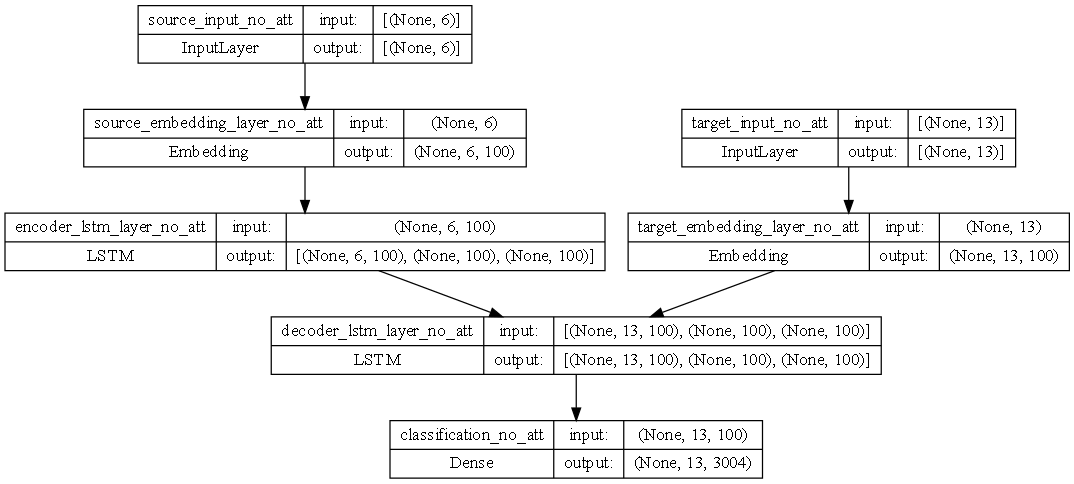

In [24]:
keras.utils.plot_model(translation_model_no_att, show_shapes=True, dpi=90)

In [25]:
# training the model
translation_model_no_att.fit(x=[train_source_input_data, train_target_input_data],
                             y=train_target_output_data,
                             validation_data=([test_source_input_data, test_target_input_data],
                                              test_target_output_data),
                             epochs=20)

Epoch 1/20
252/252 [==============================] - 7s 17ms/step - loss: 2.5558 - accuracy: 0.6407 - val_loss: 1.7038 - val_accuracy: 0.7496
Epoch 2/20
252/252 [==============================] - 3s 14ms/step - loss: 1.5687 - accuracy: 0.7644 - val_loss: 1.4854 - val_accuracy: 0.7725
Epoch 3/20
252/252 [==============================] - 3s 14ms/step - loss: 1.4118 - accuracy: 0.7759 - val_loss: 1.3739 - val_accuracy: 0.7883
Epoch 4/20
252/252 [==============================] - 3s 14ms/step - loss: 1.3015 - accuracy: 0.7910 - val_loss: 1.2978 - val_accuracy: 0.7969
Epoch 5/20
252/252 [==============================] - 3s 14ms/step - loss: 1.2235 - accuracy: 0.7988 - val_loss: 1.2423 - val_accuracy: 0.8032
Epoch 6/20
252/252 [==============================] - 4s 14ms/step - loss: 1.1536 - accuracy: 0.8078 - val_loss: 1.1903 - val_accuracy: 0.8120
Epoch 7/20
252/252 [==============================] - 3s 14ms/step - loss: 1.0904 - accuracy: 0.8149 - val_loss: 1.1493 - val_accuracy: 0.8145

# 4. Inference Model
Now that the model has been trained, we want the ability of giving the model an enligh input and have it output the translated text of that input. Noticed how the model was trained. We feed into the model a list of trained_source_input_id and train_target_input_id. Realistically, we do not have trained_input_id in real life so we much architect the inference model carefully. Luckily, keras models can return layers with all the trained weights.

In [ ]:
translation_model_no_att.layers

In [26]:
def build_inference_model(latent_dim=100):
    """
        inference model that only used the trained weights for each encoder/decoder
    """
    
    # encoder architecture
    encoder_input = translation_model_no_att.get_layer('source_input_no_att').input
    encoder_embedding = translation_model_no_att.get_layer('source_embedding_layer_no_att')(encoder_input)
    encoder_output, encoder_state_h, encoder_state_c = translation_model_no_att.get_layer('encoder_lstm_layer_no_att')(encoder_embedding)
    encoder_model = keras.Model(inputs=encoder_input, 
                                outputs=[encoder_state_h, encoder_state_c])

    # decoder architecture
    # take the decoder; perform embeddiong
    decoder_input = keras.layers.Input(shape=(1,))
    decoder_embedding = translation_model_no_att.get_layer('target_embedding_layer_no_att')(decoder_input)

    # declre some dummy initial state with matching dimension as the input state
    decoder_state_input_h = keras.layers.Input(shape=(latent_dim,))
    decoder_state_input_c = keras.layers.Input(shape=(latent_dim,))
    decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    # run through the decoder lstm
    decoder_outputs, state_h, state_c = translation_model_no_att.get_layer('decoder_lstm_layer_no_att')(decoder_embedding, decoder_state_inputs)
    decoder_states = [state_h, state_c]
    
    # get the dense output classification layer
    # cosntruct the decoder model
    decoder_outputs = translation_model_no_att.get_layer("classification_no_att")(decoder_outputs)
    decoder_model = keras.Model(inputs=[decoder_input] + decoder_state_inputs,
                          outputs=[decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model

In [27]:
encoder_model, decoder_model = build_inference_model()

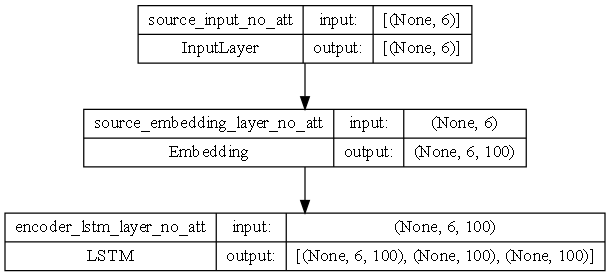

In [28]:
keras.utils.plot_model(encoder_model, show_shapes=True, dpi=90)

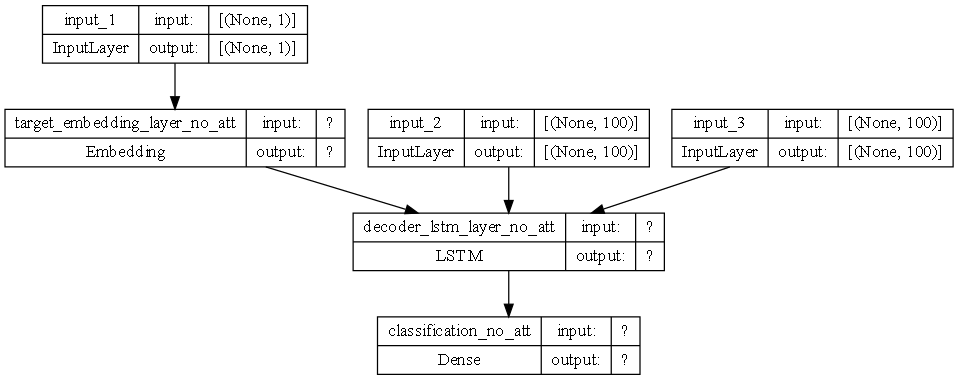

In [29]:
keras.utils.plot_model(decoder_model, show_shapes=True, dpi=90)

In [30]:
# testing the encoder input
encoded_input_words = [source_id_vocab_dict[i] for i in test_source_input_data[2]]
encoded_input_words

['wow', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>']

In [31]:
# encoder step, 
# encode the input to create state values
states_value  = encoder_model.predict(test_source_input_data[0].reshape(1, max_encoder_seq_length))

1/1 [==============================] - 0s 399ms/step


In [32]:
# generate a start token, pad the rest with nothing
target_seq = np.zeros((1, 1))

# Populate the first character of target sequence with the start character.
target_seq[0, 0] = target_vocab_id_dict["<start>"]
target_seq

array([[3001.]])

In [50]:
# try first round of decoder
output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
sampled_token_index = np.argmax(output_tokens[0, -1])
target_id_vocab_dict[sampled_token_index]

1/1 [==============================] - 0s 22ms/step


'danke'

In [51]:
def translate_sentence(input_seq, max_out_len=max_decoder_seq_length):
    # encode the starting sentence
    states_value = encoder_model.predict(input_seq)
    
    # initialize the starting word
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_vocab_id_dict['<start>']
    eos = target_vocab_id_dict['<end>']
    output_sentence = []

    # iterate through the max length of the input text
    for _ in range(max_out_len):
        
        # perform model output using the input state and initialized target token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, -1])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = target_id_vocab_dict[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [52]:
# testing the encoder input
encoded_input_words = [source_id_vocab_dict[i] for i in test_source_input_data[2]]
encoded_input_words

['stop', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>']

In [53]:
translated_text = translate_sentence(test_source_input_data[2].reshape(1, max_encoder_seq_length))
translated_text

1/1 [==============================] - 0s 21ms/step


'hör auf zu <unk>'

# Seq2Seq Experimental Zone

In [38]:
# configuration
batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [39]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 83
Max sequence length for inputs: 15
Max sequence length for outputs: 51


In [77]:
decoder_input_data[:1][0][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [78]:
decoder_target_data[:2][0][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [40]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [41]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("../data/s2s.h5")

Epoch 1/50
125/125 [==============================] - 6s 24ms/step - loss: 1.3031 - accuracy: 0.6886 - val_loss: 1.2215 - val_accuracy: 0.6644
Epoch 2/50
125/125 [==============================] - 2s 17ms/step - loss: 0.9068 - accuracy: 0.7600 - val_loss: 0.9299 - val_accuracy: 0.7499
Epoch 3/50
125/125 [==============================] - 2s 17ms/step - loss: 0.7257 - accuracy: 0.8020 - val_loss: 0.8048 - val_accuracy: 0.7748
Epoch 4/50
125/125 [==============================] - 2s 17ms/step - loss: 0.6305 - accuracy: 0.8216 - val_loss: 0.7427 - val_accuracy: 0.7900
Epoch 5/50
125/125 [==============================] - 2s 17ms/step - loss: 0.5765 - accuracy: 0.8350 - val_loss: 0.6971 - val_accuracy: 0.8040
Epoch 6/50
125/125 [==============================] - 2s 17ms/step - loss: 0.5365 - accuracy: 0.8461 - val_loss: 0.6551 - val_accuracy: 0.8134
Epoch 7/50
125/125 [==============================] - 2s 17ms/step - loss: 0.5042 - accuracy: 0.8544 - val_loss: 0.6377 - val_accuracy: 0.8178

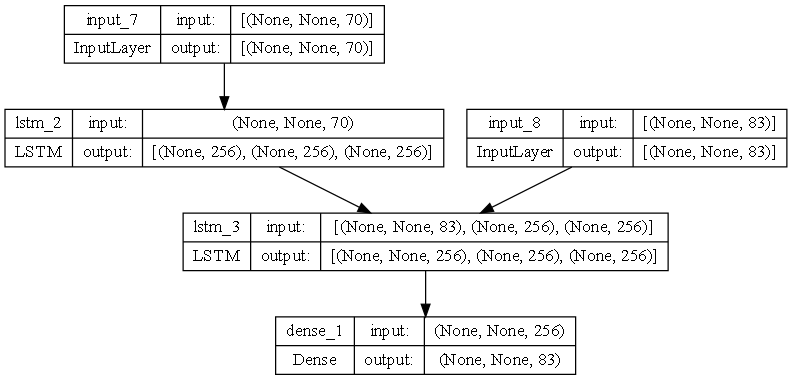

In [59]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [126]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("../data/s2s.h5")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
        # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        print(sampled_char)
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        
        print(sampled_token_index, target_seq.shape)


        # Update states
        states_value = [h, c]
    return decoded_sentence

In [129]:
reverse_target_char_index

{0: '\t',
 1: '\n',
 2: ' ',
 3: '!',
 4: '$',
 5: '%',
 6: "'",
 7: ',',
 8: '-',
 9: '.',
 10: '0',
 11: '1',
 12: '2',
 13: '3',
 14: '4',
 15: '5',
 16: '7',
 17: '8',
 18: '9',
 19: ':',
 20: '?',
 21: 'A',
 22: 'B',
 23: 'C',
 24: 'D',
 25: 'E',
 26: 'F',
 27: 'G',
 28: 'H',
 29: 'I',
 30: 'J',
 31: 'K',
 32: 'L',
 33: 'M',
 34: 'N',
 35: 'O',
 36: 'P',
 37: 'R',
 38: 'S',
 39: 'T',
 40: 'U',
 41: 'V',
 42: 'W',
 43: 'Y',
 44: 'Z',
 45: 'a',
 46: 'b',
 47: 'c',
 48: 'd',
 49: 'e',
 50: 'f',
 51: 'g',
 52: 'h',
 53: 'i',
 54: 'j',
 55: 'k',
 56: 'l',
 57: 'm',
 58: 'n',
 59: 'o',
 60: 'p',
 61: 'q',
 62: 'r',
 63: 's',
 64: 't',
 65: 'u',
 66: 'v',
 67: 'w',
 68: 'x',
 69: 'y',
 70: 'z',
 71: '\xa0',
 72: 'Ä',
 73: 'Ö',
 74: 'Ü',
 75: 'ß',
 76: 'ä',
 77: 'ö',
 78: 'ü',
 79: '’',
 80: '“',
 81: '„',
 82: '\u202f'}

In [127]:
encoder_input_data[seq_index : seq_index + 1]


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [128]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 372ms/step
G
27 (1, 1, 83)
1/1 [==============================] - 0s 22ms/step
e
49 (1, 1, 83)
1/1 [==============================] - 0s 23ms/step
h
52 (1, 1, 83)
1/1 [==============================] - 0s 21ms/step
 
2 (1, 1, 83)
1/1 [==============================] - 0s 22ms/step
m
57 (1, 1, 83)
1/1 [==============================] - 0s 22ms/step
i
53 (1, 1, 83)
1/1 [==============================] - 0s 23ms/step
r
62 (1, 1, 83)
1/1 [==============================] - 0s 24ms/step
!
3 (1, 1, 83)
1/1 [==============================] - 0s 26ms/step


1 (1, 1, 83)
-
Input sentence: go .
Decoded sentence: Geh mir!

1/1 [==============================] - 0s 22ms/step
H
28 (1, 1, 83)
1/1 [==============================] - 0s 23ms/step
a
45 (1, 1, 83)
1/1 [==============================] - 0s 24ms/step
l
56 (1, 1, 83)
1/1 [==============================] - 0s 31ms/step
l
56 (1, 1, 83)
1/1 [==============================] - 0s 22ms/step
o
59 (1, 1, 83)

1/1 [==============================] - 0s 24ms/step
B
22 (1, 1, 83)
1/1 [==============================] - 0s 26ms/step
l
56 (1, 1, 83)
1/1 [==============================] - 0s 24ms/step
e
49 (1, 1, 83)
1/1 [==============================] - 0s 25ms/step
i
53 (1, 1, 83)
1/1 [==============================] - 0s 24ms/step
b
46 (1, 1, 83)
1/1 [==============================] - 0s 25ms/step
!
3 (1, 1, 83)
1/1 [==============================] - 0s 24ms/step


1 (1, 1, 83)
-
Input sentence: stay .
Decoded sentence: Bleib!

1/1 [==============================] - 0s 24ms/step
S
38 (1, 1, 83)
1/1 [==============================] - 0s 25ms/step
t
64 (1, 1, 83)
1/1 [==============================] - 0s 24ms/step
o
59 (1, 1, 83)
1/1 [==============================] - 0s 23ms/step
p
60 (1, 1, 83)
1/1 [==============================] - 0s 25ms/step
p
60 (1, 1, 83)
1/1 [==============================] - 0s 24ms/step
 
2 (1, 1, 83)
1/1 [==============================] - 0s 25ms/step
s
63 (1, 1, 83)
